In [1]:
import os, json, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import FunctionTransformer
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime

# Paths
DATA_PATH   = Path("/Users/macaryan/Coding/Shodh_AI/lendingclub-policy-optimization/data/accepted_2007_to_2018Q4.csv")   # adjust if filename differs
PREPROC_PKL = Path("/Users/macaryan/Coding/Shodh_AI/lendingclub-policy-optimization/notebooks/preprocessor.joblib")
ARTIFACTS   = Path(".")
ARTIFACTS.mkdir(exist_ok=True)

plt.rcParams["figure.figsize"] = (6,4)
pd.set_option("display.max_columns", 200)

# Reuse the same feature lists as Task-1
NUM_COLS = ["loan_amnt","int_rate","emp_length","annual_inc","dti","delinq_2yrs",
            "inq_last_6mths","open_acc","pub_rec","revol_util","total_acc","mort_acc",
            "fico_range_low","fico_range_high"]
CAT_COLS = ["term","home_ownership","verification_status","purpose","addr_state","application_type"]
META_COLS = ["issue_d","loan_amnt","int_rate"]


In [18]:
# Make 'src' importable from notebooks
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


In [2]:
# Target mapping
DEFAULTS = {
    "Charged Off","Default","Late (31-120 days)","Late (16-30 days)",
    "Does not meet the credit policy. Status:Charged Off"
}
PAID = {"Fully Paid","Does not meet the credit policy. Status:Fully Paid"}

def pct_to_float(s: pd.Series):
    return pd.to_numeric(s.astype(str).str.replace("%","", regex=False), errors="coerce")/100.0

def term_to_months(s: pd.Series):
    return pd.to_numeric(s.astype(str).str.extract(r"(\d+)")[0], errors="coerce")

def emp_to_years(s: pd.Series):
    s = s.astype(str).str.lower().str.strip()
    s = s.replace({"n/a": np.nan})
    s = s.str.replace("< 1 year","0", regex=False)
    s = s.str.replace("10+ years","10", regex=False)
    return pd.to_numeric(s.str.extract(r"(\d+)")[0], errors="coerce")


In [7]:
df = pd.read_csv(DATA_PATH, low_memory=False)

# keep only statuses we can map to binary; drop 'Current'
df = df[df["loan_status"].isin(DEFAULTS | PAID)].copy()
df["y"] = df["loan_status"].isin(DEFAULTS).astype(int)

# parse issue_d to datetime
df["issue_d"] = pd.to_datetime(df["issue_d"], format="%b-%Y", errors="coerce")
df = df.dropna(subset=["issue_d"]).sort_values("issue_d")

# Select pre-decision columns + meta
keep = [c for c in (NUM_COLS + CAT_COLS + META_COLS + ["y"]) if c in df.columns]
df = df[keep].copy()

# conversions
if "int_rate" in df:      df["int_rate"]  = pct_to_float(df["int_rate"])
if "revol_util" in df:    df["revol_util"]= pct_to_float(df["revol_util"])
if "term" in df:          df["term"]      = term_to_months(df["term"])
if "emp_length" in df:    df["emp_length"]= emp_to_years(df["emp_length"])

for c in NUM_COLS:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# time split
train = df[df["issue_d"] < "2017-01-01"].copy()
valid = df[(df["issue_d"] >= "2017-01-01") & (df["issue_d"] < "2018-01-01")].copy()
test  = df[df["issue_d"] >= "2018-01-01"].copy()

def get_blocks(frame):
    X = frame[NUM_COLS + CAT_COLS].copy()
    y = frame["y"].values.astype(np.int64)
    meta = frame[["loan_amnt","int_rate"]].copy()
    return X, y, meta

Xtr_raw, ytr, tr_meta = get_blocks(train)
Xva_raw, yva, va_meta = get_blocks(valid)
Xte_raw, yte, te_meta = get_blocks(test)

print("Shapes (raw):", Xtr_raw.shape, Xva_raw.shape, Xte_raw.shape)
print("Class balance train (1=default):", ytr.mean().round(4))


AttributeError: 'DataFrame' object has no attribute 'str'

In [ ]:
df.columns = df.columns.str.strip()           # remove hidden spaces
df = df.loc[:, ~df.columns.duplicated()] 

# conversions
if "int_rate" in df:      df["int_rate"]  = pct_to_float(df["int_rate"])
if "revol_util" in df:    df["revol_util"]= pct_to_float(df["revol_util"])
if "term" in df:          df["term"]      = term_to_months(df["term"])
if "emp_length" in df:    df["emp_length"]= emp_to_years(df["emp_length"])

for c in NUM_COLS:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# time split
train = df[df["issue_d"] < "2017-01-01"].copy()
valid = df[(df["issue_d"] >= "2017-01-01") & (df["issue_d"] < "2018-01-01")].copy()
test  = df[df["issue_d"] >= "2018-01-01"].copy()

def get_blocks(frame):
    X = frame[NUM_COLS + CAT_COLS].copy()
    y = frame["y"].values.astype(np.int64)
    meta = frame[["loan_amnt","int_rate"]].copy()
    return X, y, meta

Xtr_raw, ytr, tr_meta = get_blocks(train)
Xva_raw, yva, va_meta = get_blocks(valid)
Xte_raw, yte, te_meta = get_blocks(test)

print("Shapes (raw):", Xtr_raw.shape, Xva_raw.shape, Xte_raw.shape)
print("Class balance train (1=default):", ytr.mean().round(4))

Shapes (raw): (1129956, 20) (178817, 20) (65142, 20)
Class balance train (1=default): 0.2025


In [20]:
preprocessor = joblib.load(PREPROC_PKL)

def transform_df(pre, X_df):
    X = pre.transform(X_df)
    # ColumnTransformer may return sparse; convert to dense for PyTorch if needed
    if hasattr(X, "toarray"):
        X = X.toarray()
    return X

Xtr = transform_df(preprocessor, Xtr_raw)
Xva = transform_df(preprocessor, Xva_raw)
Xte = transform_df(preprocessor, Xte_raw)

Xtr.shape, Xva.shape, Xte.shape


((1129956, 63), (178817, 63), (65142, 63))

In [19]:
import importlib
import src
from src import features
from src.features import make_preprocessor
print("OK: src.features is importable")


OK: src.features is importable


In [21]:
class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.10),
            nn.Linear(256, 128),    nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.10),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

def train_mlp(X_tr, y_tr, X_va, y_va, pos_weight=None, epochs=20, bs=4096, lr=1e-3):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = MLP(X_tr.shape[1]).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    if pos_weight is None:
        loss_fn = nn.BCEWithLogitsLoss()
    else:
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))
    tr_loader = DataLoader(TensorDataset(torch.from_numpy(X_tr).float(),
                                         torch.from_numpy(y_tr).float()),
                           batch_size=bs, shuffle=True, drop_last=False)
    best_auc, best_state = -1, None
    for ep in range(1, epochs+1):
        model.train()
        for xb, yb in tr_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            opt.zero_grad(); loss.backward(); opt.step()
        # validate
        model.eval()
        with torch.no_grad():
            va_logits = model(torch.from_numpy(X_va).float().to(device)).cpu().numpy().ravel()
            va_probs  = 1/(1+np.exp(-va_logits))
            auc_val   = roc_auc_score(y_va, va_probs)
        if auc_val > best_auc:
            best_auc, best_state = auc_val, model.state_dict().copy()
        print(f"Epoch {ep:02d} | Val AUC: {auc_val:.4f}")
    model.load_state_dict(best_state)
    return model, best_auc

def predict_proba(model, X):
    device = next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        logits = model(torch.from_numpy(X).float().to(device)).cpu().numpy().ravel()
        return 1/(1+np.exp(-logits))


In [22]:
# class imbalance weight: neg/pos
pos = ytr.sum()
neg = len(ytr) - pos
pos_weight = float(neg / max(pos, 1))

model, best_val_auc = train_mlp(Xtr, ytr, Xva, yva, pos_weight=pos_weight, epochs=20, bs=4096, lr=1e-3)
print("Best Val AUC:", round(best_val_auc, 4))

# Evaluate on test
p_va = predict_proba(model, Xva)
p_te = predict_proba(model, Xte)

auc_val = roc_auc_score(yva, p_va)
auc_te  = roc_auc_score(yte, p_te)

f1_val_05 = f1_score(yva, (p_va >= 0.5).astype(int))
f1_te_05  = f1_score(yte, (p_te >= 0.5).astype(int))

print(f"Val  AUC: {auc_val:.4f} | F1@0.5: {f1_val_05:.4f}")
print(f"Test AUC: {auc_te:.4f} | F1@0.5: {f1_te_05:.4f}")


Epoch 01 | Val AUC: 0.7043
Epoch 02 | Val AUC: 0.7056
Epoch 03 | Val AUC: 0.7044
Epoch 04 | Val AUC: 0.7036
Epoch 05 | Val AUC: 0.7066
Epoch 06 | Val AUC: 0.7063
Epoch 07 | Val AUC: 0.7043
Epoch 08 | Val AUC: 0.7063
Epoch 09 | Val AUC: 0.7061
Epoch 10 | Val AUC: 0.7070
Epoch 11 | Val AUC: 0.7055
Epoch 12 | Val AUC: 0.7046
Epoch 13 | Val AUC: 0.7070
Epoch 14 | Val AUC: 0.7046
Epoch 15 | Val AUC: 0.7037
Epoch 16 | Val AUC: 0.7054
Epoch 17 | Val AUC: 0.7057
Epoch 18 | Val AUC: 0.7046
Epoch 19 | Val AUC: 0.7061
Epoch 20 | Val AUC: 0.7063
Best Val AUC: 0.707
Val  AUC: 0.7063 | F1@0.5: 0.5033
Test AUC: 0.7064 | F1@0.5: 0.5055


In [23]:
def best_f1_threshold(y_true, probs):
    pr, rc, th = precision_recall_curve(y_true, probs)
    # derive F1 per threshold
    f1s, ths = [], []
    for t in np.linspace(0.01, 0.99, 99):
        f1s.append(f1_score(y_true, (probs >= t).astype(int)))
        ths.append(t)
    i = int(np.argmax(f1s))
    return ths[i], f1s[i]

th_opt, f1_val_opt = best_f1_threshold(yva, p_va)
f1_te_opt = f1_score(yte, (p_te >= th_opt).astype(int))
print(f"Best Val F1 @thr={th_opt:.3f}: {f1_val_opt:.4f}")
print(f"Test F1  @thr={th_opt:.3f}: {f1_te_opt:.4f}")


Best Val F1 @thr=0.470: 0.5048
Test F1  @thr=0.470: 0.5067


In [24]:
def break_even_p(int_rate, lgd=1.0, cost=0.0):
    # approve if (1-p)*G - p*L > 0  =>  p < G/(L+G), with G=int_rate, L=lgd (scale-free)
    G = np.maximum(int_rate - cost, 0.0)
    L = lgd
    return G / (L + G + 1e-12)

pstar_va = break_even_p(va_meta["int_rate"].values)
pstar_te = break_even_p(te_meta["int_rate"].values)

# DL policy: approve if p̂(default) < p*
dl_decision_va = (p_va < pstar_va).astype(int)  # 1=approve, 0=deny
dl_decision_te = (p_te < pstar_te).astype(int)

# Report F1 on default-classification viewpoint (reference only)
f1_profit_val = f1_score(yva, (p_va >= pstar_va).astype(int))
f1_profit_te  = f1_score(yte, (p_te >= pstar_te).astype(int))

print(f"Val Profit-aware F1 (reference): {f1_profit_val:.4f}")
print(f"Test Profit-aware F1 (reference): {f1_profit_te:.4f}")


Val Profit-aware F1 (reference): 0.4296
Test Profit-aware F1 (reference): 0.4294


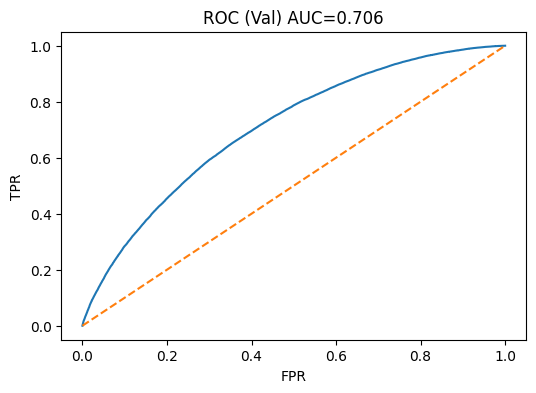

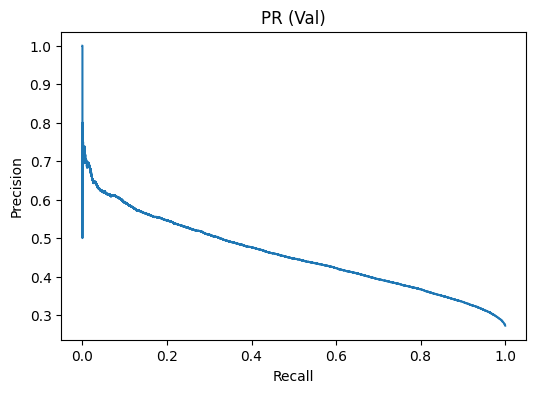

{'val_auc': 0.70629882021086,
 'test_auc': 0.7064011249300899,
 'val_f1@0.5': 0.5032741581808897,
 'test_f1@0.5': 0.5055083412023922,
 'val_best_f1_threshold': 0.47000000000000003,
 'val_best_f1': 0.5048080278014263,
 'test_f1@best_val_thr': 0.5066729563456965,
 'val_profit_ref_f1': 0.42960620461812976,
 'test_profit_ref_f1': 0.4294059778714308}

In [25]:
# ROC & PR curves (validation)
fpr, tpr, _ = roc_curve(yva, p_va)
prec, rec, _ = precision_recall_curve(yva, p_va)

plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); plt.title(f"ROC (Val) AUC={auc(fpr,tpr):.3f}")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

plt.plot(rec, prec); plt.title("PR (Val)")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.show()

# Save artifacts
torch.save(model.state_dict(), ARTIFACTS / "mlp_model.pt")
np.save(ARTIFACTS / "test_predictions.npy", p_te)

metrics = {
    "val_auc": float(auc_val),
    "test_auc": float(auc_te),
    "val_f1@0.5": float(f1_val_05),
    "test_f1@0.5": float(f1_te_05),
    "val_best_f1_threshold": float(th_opt),
    "val_best_f1": float(f1_val_opt),
    "test_f1@best_val_thr": float(f1_te_opt),
    "val_profit_ref_f1": float(f1_profit_val),
    "test_profit_ref_f1": float(f1_profit_te),
}
with open(ARTIFACTS / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

metrics
